# **Import Library Yang Dibutuhkan**

In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, GlobalMaxPooling1D, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np
import json
import nltk
from nltk.corpus import stopwords

# **Upload dan Baca Data**

In [2]:
from google.colab import files

# Upload file
uploaded = files.upload()

Saving dataset.csv to dataset (1).csv


In [3]:
# Membaca file
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

# Pemetaan Label Sentimen

In [4]:
# Memetakan label sentimen ke kelas numerik
label_mapping = {"Positive": 0, "Neutral": 1, "Negative": 2}
df["Sentiment"] = df["Sentiment"].map(label_mapping)

# Cleaning Data

In [5]:
# Mengunduh stopwords bahasa Indonesia
nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian'))  # Stopwords bahasa Indonesia

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in stop_words])

# Menghapus stopwords dari teks
df["Notification_Text"] = df["Notification_Text"].apply(remove_stopwords)

# Mempersiapkan Data untuk Pelatihan

In [7]:
# Memisahkan teks dan label
texts = df["Notification_Text"].values
labels = df["Sentiment"].values

In [8]:
texts_train, texts_val, labels_train, labels_val = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

# Tokenisasi dan Padding Teks

In [9]:
# Parameter untuk tokenizer
max_vocab = 2000
max_seq_length = 128
filters = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ '  # Menghapus simbol

In [10]:
# Tokenizer dengan filters
tokenizer = Tokenizer(num_words=max_vocab, oov_token="<OOV>", filters=filters)
tokenizer.fit_on_texts(texts_train)

word_index = tokenizer.word_index
print(f"Jumlah kata unik: {len(word_index)}")

Jumlah kata unik: 1965


In [11]:
# Menyimpan word_index ke file JSON
with open('word_index.json', 'w') as fp:
    json.dump(word_index, fp)

In [12]:
train_sequences = tokenizer.texts_to_sequences(texts_train)
val_sequences = tokenizer.texts_to_sequences(texts_val)

train_padded = pad_sequences(
    train_sequences, maxlen=max_seq_length, padding='post', truncating='post'
)
val_padded = pad_sequences(
    val_sequences, maxlen=max_seq_length, padding='post', truncating='post'
)

# Membangun Model

In [13]:
model = tf.keras.Sequential([
    Embedding(input_dim=max_vocab, output_dim=128, input_shape=(max_seq_length,)),
    Bidirectional(LSTM(64, return_sequences=True)),
    GlobalMaxPooling1D(),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(3, activation="softmax")  # 3 kelas sentimen
])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 128, 128)            │         256,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128, 128)            │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 363,267 (1.39 MB)

 Trainable params: 363,267 (1.39 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Training Model

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

num_epochs = 50
history = model.fit(
    train_padded, labels_train,
    validation_data=(val_padded, labels_val),
    epochs=num_epochs,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - accuracy: 0.3849 - loss: 1.0953 - val_accuracy: 0.4500 - val_loss: 1.0875
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step - accuracy: 0.4791 - loss: 1.0667 - val_accuracy: 0.4800 - val_loss: 1.0157
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - accuracy: 0.6842 - loss: 0.8923 - val_accuracy: 0.5550 - val_loss: 1.1505
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 0.7298 - loss: 0.7273 - val_accuracy: 0.7500 - val_loss: 0.6428
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 270ms/step - accuracy: 0.8962 - loss: 0.3834 - val_accuracy: 0.7750 - val_loss: 0.5632
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - accuracy: 0.9603 - loss: 0.1652 - val_accuracy: 0.8150 - val_loss: 0.5835
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 234ms/step - accuracy: 0.9807 - loss: 0.0922 - val_accuracy: 0.8150 - val_loss: 0.6015
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - accuracy: 0.9926 - loss: 0.0444 - val_accuracy: 0.

# Visualisasi Akurasi

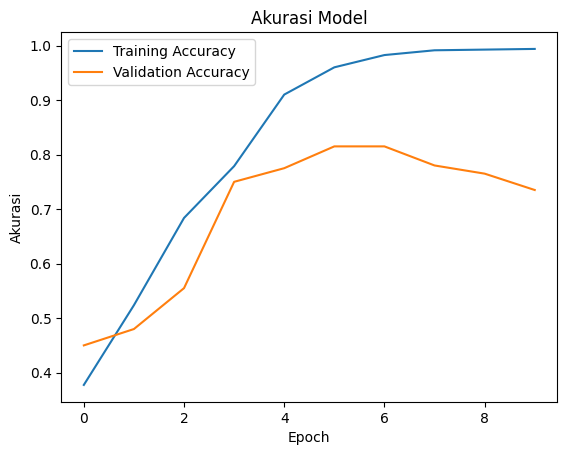

In [16]:
plt.figure()
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Akurasi Model")
plt.xlabel("Epoch")
plt.ylabel("Akurasi")
plt.legend()
plt.show()

# Melakukan Tes Terhadap Model yang Dihasilkan

In [19]:
def predict_sentiment_with_proba(text, model, tokenizer, max_seq_length):
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_seq_length, padding="post", truncating="post")
    prediction = model.predict(padded_sequence)
    sentiment_map = {0: "Positive", 1: "Neutral", 2: "Negative"}
    predicted_class = np.argmax(prediction)
    confidence = prediction[0][predicted_class]
    return sentiment_map[predicted_class], confidence

In [24]:
text = "cantik banget sayang"
sentiment, confidence = predict_sentiment_with_proba(text, model, tokenizer, max_seq_length)
print(f"Prediksi Sentimen: {sentiment}, Confidence: {confidence:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediksi Sentimen: Positive, Confidence: 0.65


# Menyimpan Model dan Tokenizer

In [17]:
model.save("sentiment_model.h5")

In [18]:
files.download("sentiment_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
import pickle

# Menyimpan tokenizer ke dalam file
with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

In [27]:
# Mengunduh file ke lokal
files.download('tokenizer.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>